# Fast food and health    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
#ssl error on osx fix
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
%matplotlib inline

/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# load county population data
df_county = pd.read_csv('data/county.csv', index_col=False)
df_county = df_county.dropna()

# load restaurant data
df_restaurants = pd.read_csv('data/restaurants.csv', index_col=False)
df_restaurants = df_restaurants.dropna()

# load grocery store data
df_stores = pd.read_csv('data/stores.csv', index_col=False)
df_stores = df_stores.dropna()

# load health data
df_health = pd.read_csv('data/health.csv', index_col=False)
df_health = df_health.dropna()

In [3]:
# restaurants in 2009 and 2014
# Fast food, full service, and expenditures per capita on fast food and restaurants (2007 and 2012)
rests_09 = df_restaurants[['FIPS', 'State', 'County', 'FFR09', 'PC_FFRSALES07', 'FSR09', 'PC_FSRSALES07']]
rests_14 = df_restaurants[['FIPS', 'State', 'County', 'FFR14', 'PC_FFRSALES12', 'FSR14', 'PC_FSRSALES12']]
print("Average % change in number of fast food restaurants per 1000 pop: ", np.mean(df_restaurants['PCH_FFRPTH_09_14']))
# This shows that the average consumption in fast food is slightly increasing

print("Average % change in number of full service restaurants per 1000 pop: ", np.mean(df_restaurants['PCH_FSRPTH_09_14']))
# This hsows that the average consumption in full service restaurants in increasing, but not as much as fast food

Average % change in number of fast food restaurants per 1000 pop:  4.8059159891103445
Average % change in number of full service restaurants per 1000 pop:  3.679059409120473


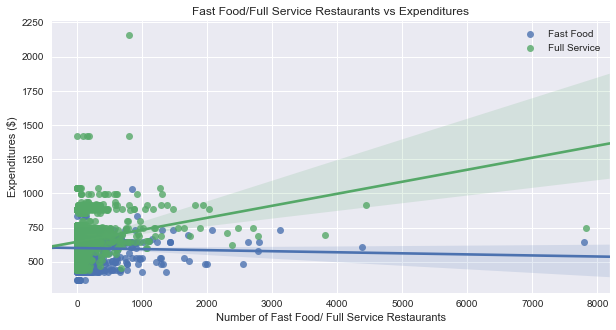

In [4]:
plt.figure(figsize=(10,5))
plt.title("Fast Food/Full Service Restaurants vs Expenditures")
sns.regplot(x = 'FFR14', y = 'PC_FFRSALES12', data = rests_14, label='Fast Food')
sns.regplot(x = 'FSR14', y = 'PC_FSRSALES12', data = rests_14, label='Full Service')
plt.ylabel("Expenditures ($)")
plt.xlabel("Number of Fast Food/ Full Service Restaurants")
plt.legend()
plt.show()
# This shows that there is more expenditure per capita in restaurants than fast food for counties with
# more full service restaurants, which perhaps is a way to combat high fast food consumption

In [5]:
# stores in 2009 and 2014
# Grocery, Supermarket, Convenience, and Specialized stores
stores_09 = df_stores[['FIPS', 'State', 'County', 'GROC09', 'SUPERC09', 'CONVS09', 'SPECS09']]
stores_14 = df_stores[['FIPS', 'State', 'County', 'GROC14', 'SUPERC14', 'CONVS14', 'SPECS14']]

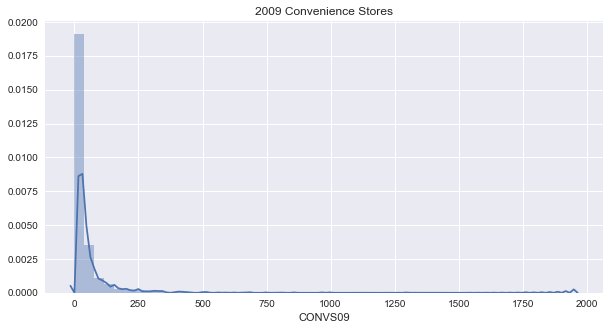

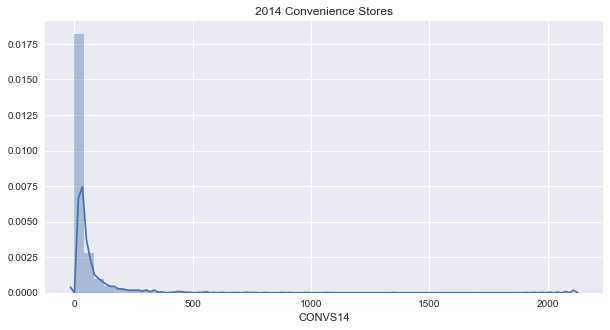

In [6]:
plt.figure(figsize=(10,5))
plt.title("2009 Convenience Stores")
sns.distplot(stores_09.dropna().CONVS09, hist='True')
plt.show()

plt.figure(figsize=(10,5))
plt.title("2014 Convenience Stores")
sns.distplot(stores_14.dropna().CONVS14, hist='True')
plt.show()

In [7]:
# health in 2008-09 and 2013-14
# Diabetes rate, Obesity rate, rec and facities count
health_0809 = df_health[['FIPS', 'State', 'County', 'PCT_DIABETES_ADULTS08', 'PCT_OBESE_ADULTS08', 'RECFAC09']]
health_1314 = df_health[['FIPS', 'State', 'County', 'PCT_DIABETES_ADULTS13', 'PCT_OBESE_ADULTS13', 'RECFAC14']]

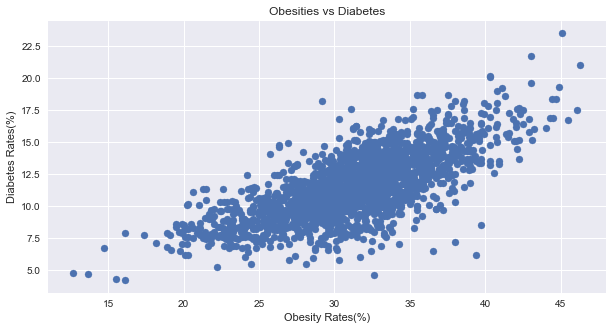

In [8]:
plt.figure(figsize=(10,5))
plt.title("Obesities vs Diabetes")
# sns.barplot('PCT_OBESE_ADULTS13', 'PCT_DIABETES_ADULTS13', data = health_1314)
# I think the below is better for visualizing trend
plt.scatter(health_1314['PCT_OBESE_ADULTS13'], health_1314['PCT_DIABETES_ADULTS13'])
plt.xlabel("Obesity Rates(%)")
plt.ylabel("Diabetes Rates(%)")
plt.show()

In [9]:
split = int(health_1314.shape[0] * 0.8)
diabetes_train = health_1314["PCT_DIABETES_ADULTS13"][:split]
diabetes_valid = health_1314["PCT_DIABETES_ADULTS13"][split:]
obesity_train = health_1314["PCT_OBESE_ADULTS13"][:split]
obesity_valid = health_1314["PCT_OBESE_ADULTS13"][split:]

In [10]:
myOLS = sm.OLS(diabetes_train, obesity_train).fit()
diabetes_hat = myOLS.predict(obesity_valid)
mse = 1/len(diabetes_valid)*np.dot((diabetes_valid - diabetes_hat),(diabetes_valid - diabetes_hat))
print("The MSE for the model obesity~diabetes is:", mse)

The MSE for the model obesity~diabetes is: 3.85752534133


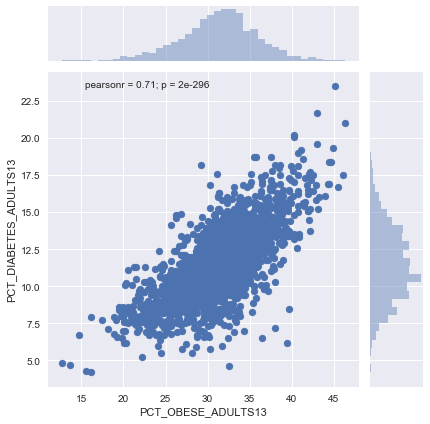

In [11]:
sns.jointplot('PCT_OBESE_ADULTS13', 'PCT_DIABETES_ADULTS13', data = health_1314)
plt.show()

## Linear Regression

In [12]:
linreg = LinearRegression()

#80-20 train-test split
split = int(len(health_1314.PCT_OBESE_ADULTS13) * 0.8)

X = health_1314.PCT_OBESE_ADULTS13.values.reshape(-1,1)
X_train, X_test = (X[:split], X[split:])

y = health_1314.PCT_DIABETES_ADULTS13.values.reshape(-1,1)
y_train, y_test = (y[:split], y[split:])

model = linreg.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("%change in obesity vs. %change in diabetes MSE: ", mean_squared_error(y_test, y_pred))
print("%change in obesity vs. %change in diabetes R2-score: ", model.score(X_test, y_test))

%change in obesity vs. %change in diabetes MSE:  3.82727404393
%change in obesity vs. %change in diabetes R2-score:  0.46232564056


## Logistic Regression

In [13]:
def change(diff):
        return diff > 0

logreg = LogisticRegression()
df_rest_health = df_restaurants[['County', 'PCH_FFR_09_14']].merge(
    df_health[['County', 'PCT_OBESE_ADULTS08', 'PCT_OBESE_ADULTS13', 
               'PCT_DIABETES_ADULTS08', 'PCT_DIABETES_ADULTS13']]).dropna()

#80-20 train-test split
split = int(len(df_rest_health) * 0.8)

X = df_rest_health.PCH_FFR_09_14.values.reshape(-1,1)
X_train, X_test = (X[:split], X[split:])

y_obesity =  np.ravel(df_rest_health.PCT_OBESE_ADULTS13.sub(df_rest_health.PCT_OBESE_ADULTS08).map(change))
y_obesity_train, y_obesity_test = (y_obesity[:split], y_obesity[split:])

model_obesity = logreg.fit(X_train, y_obesity_train)
y_obesity_pred = model_obesity.predict(X_test)
print("Fast food restaurant % change vs. change in obesity MSE: ",
      mean_squared_error(y_obesity_test, y_obesity_pred))
print("Fast food restaurant % change vs. change in obesity R2-score: ", 
      model_obesity.score(X_test, y_obesity_test))
print() 

y_diabetes =  np.ravel(df_rest_health.PCT_DIABETES_ADULTS13.sub(df_rest_health.PCT_DIABETES_ADULTS08).map(change))
y_diabetes_train, y_diabetes_test = (y_diabetes[:split], y_diabetes[split:])

model_diabetes = logreg.fit(X_train, y_diabetes_train)
y_diabetes_pred = model_diabetes.predict(X_test)
print("Fast food restaurant % change vs. change in diabetes MSE: ", 
      mean_squared_error(y_diabetes_test, y_diabetes_pred))
print("Fast food restaurant % change vs. change in diabetes R2-score: ",
      model_diabetes.score(X_test, y_diabetes_test))

Fast food restaurant % change vs. change in obesity MSE:  0.220105820106
Fast food restaurant % change vs. change in obesity R2-score:  0.779894179894

Fast food restaurant % change vs. change in diabetes MSE:  0.134920634921
Fast food restaurant % change vs. change in diabetes R2-score:  0.865079365079


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,


# Links used

https://github.com/mlberkeley/Data-Science-Decal-Fall-2017/blob/master/Day4-LogisticRegression/Finished_Logistic_Regression.ipynb

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

http://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html

http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976

